In [1]:
import requests
import sys
import time
import random
from datetime import datetime
import json
import pprint
import timeit
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import csv
import zipfile,io
import datetime
from pathlib import Path
pp=pprint.PrettyPrinter()

ImportError: cannot import name 'COMMON_SAFE_ASCII_CHARACTERS' from 'charset_normalizer.constant' (/Users/qwerty/miniforge3/envs/FAIRWork-AI-Services-Development/lib/python3.10/site-packages/charset_normalizer/constant.py)

A few examples are provided in this Jupyter notebook to demonstrate how REST API methods can be utilized to access EDMtruePLM.


#### The API includes the following methods: POST, GET, DELETE, and PUT methods, and the responses can be any of the following:

* "200":{"description": "OK"}<br>
* "401":{"description": "Unauthorized"}<br>
* "403":{"description": "Forbidden"}<br>
* "404":{"description": "Not Found"}


#### 1. API Call for generating token 

To utilize the EDMtruePLM REST APIs, a token is required .
The call is POST /api/admin/token ,which returns new server connection token

```
The data types of the Input parameters of the Method are  
{
    "clientURL":"string",
    "server"   :"string",
    "port"     :"string",
    "group"    :"string",                    
    "user"     :"string",
    "pass"     :"string"}
The output from the API method is in JSON format and the data types of the output response is 

{
  "error": "string",
  "name": "string",
  "token": "string",
  "use2FA": "boolean"} 

Example of the Output response

{'error': 'null',
 'name': 'null',
 'token': 'VT2MH5XITDBJY9JRLK',
 'use2FA': 'false'}

```


In [ ]:
PLM_URL="https://localhost:8080/EDMtruePLM"    # Client URL

GET_TOKEN_URL = PLM_URL + "/api/admin/token"      # API to get token 

# inputs arguments to the method 

getTokenData ={
    "group":"sdai-group",                 # User group
    "user":"Jotne_rc",                    # PLM User name 
    "pass":"password"}                    # PLM User Password

response={}                             

def get_token():

    print("Performing request: " + GET_TOKEN_URL)
    try:
        response = requests.post(GET_TOKEN_URL, data=getTokenData, timeout=2.0)
        response.raise_for_status()
    except requests.exceptions.RequestException as e:  
        print('request failed due to:',response.text)
        return 

    if 'error' in response.json():
        print("error: ", response.json()["error"])
    if 'token' in response.json():
        token = response.json()["token"]
        
    return token

print("the token is :",get_token())

#### 2. API call for creating new project in EDMtruePLM 

```
The API call for creating new project is, POST: /api/adm_user/{token}

In the example below Palfinger_Crane_Assembly.stp is used as input for creating a new project. 
User can use their own STEP file to create a project. The image below shows the imported project 
after API execution.

```


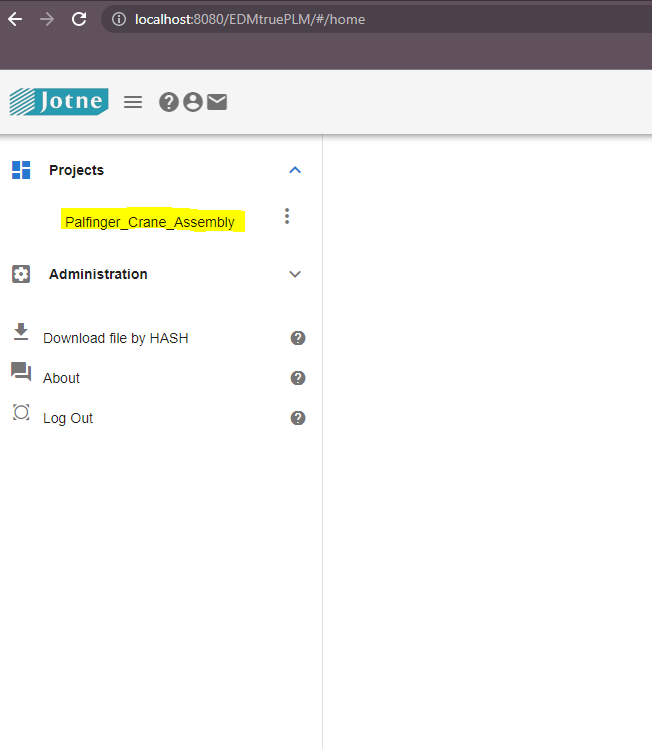

In [ ]:
##################### Create new project ###################### 

#Input parameters for the API method 

data_param={}

file = {'file': open("Palfinger_Crane_Assembly.stp",'r')} #  declaring the required step file path (.stp, .txt, .dex)

data_param={"descr":"Crane assembly",                     # description of the creating project
            "folder":"",                                  # Project folder for the new project placement
            "is_bkd_tmpl":"false",                        # Create new project as a breakdown template(true) or not(false)
            'is_tmpl':"false",                            # Create new project as a project template(true) or not(false)
            'name':"Palfinger_Crane_Assembly",            # User required Name of the Project
            'nodeType':"",                                # node type
            'src':"pdm",                                  # Type of the data file (pdm for STEP files)
            'tmpl':""}                                    # Project template model name for the new project initialization


def create_new_project(data_param,file):

    token=get_token()                                     # generating token 

    create_new_proj=PLM_URL+"/api/adm_user/"+token        # URL 

    print("\nPerforming request: " + create_new_proj)
    
    try:
        response = requests.post(create_new_proj,files=file,data=data_param,timeout=30.0)
        response.raise_for_status()
    except requests.exceptions.RequestException as e:  
        print('request failed due to:',response.text)
        return 
       
    return response.json()

new_project_information=create_new_project(data_param,file)
pp.pprint(new_project_information)  




#### 3.API call for retrieving all projects information associated with the current EDMtruePLM user 

```
 GET /api/adm_user/all_user_proj/{token}, to generate a list of projects associated with the user

This method is used to obtain an overview of projects created by the EDMtruePLM user. This call returns meta data of projects such as project name, project creation and end dates.

```
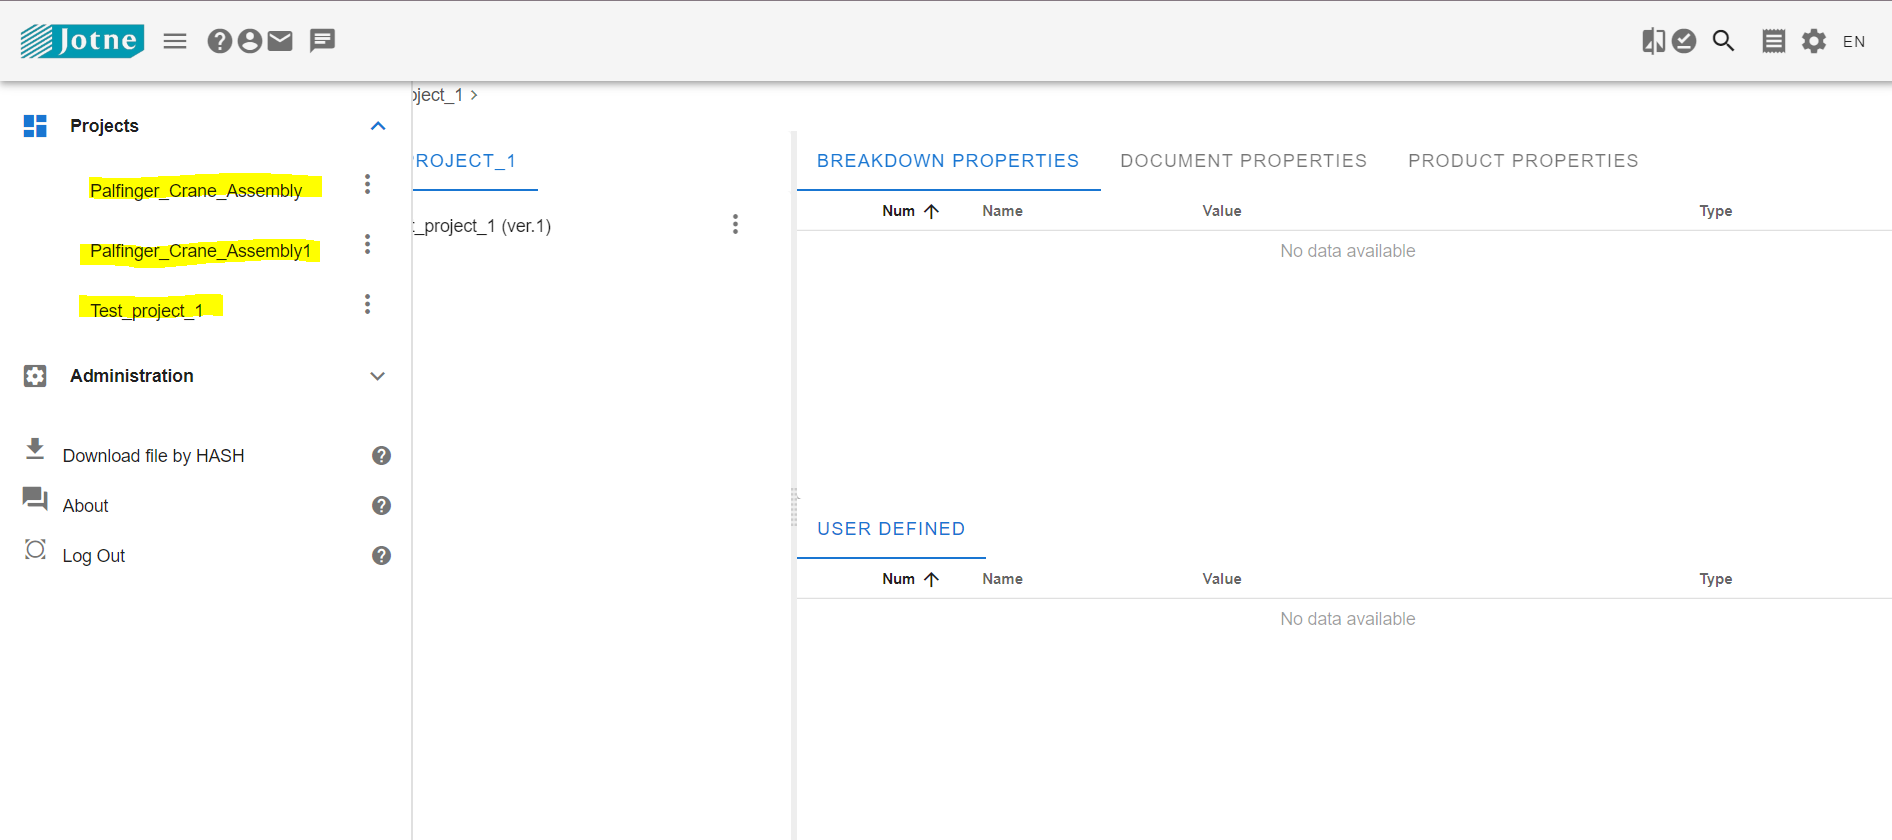

In [ ]:
##################### project information ###################### 

def get_current_projects_info():

    token=get_token()                                            

    url_get_proj_info=PLM_URL+"/api/adm_user/all_user_proj/"+token   # URL for getting the projects info

    print("\nPerforming request: " + url_get_proj_info)

    try:
        response = requests.get(url_get_proj_info, timeout=2.0)
        response.raise_for_status()
    except requests.exceptions.RequestException as e:  
        print('request failed due to:',response.text)
        return 
    if response.status_code!=200:
        print("\tRequest failed (error code = " + str(response.text) + ")")
    else:
        return response.json()
    
    
response=get_current_projects_info()
pp.pprint(response)   


# Formatting the output

current_user_projs=response

for i in range(len(current_user_projs)):
    print('\n')
    print('The Project name is : {} , guid is : {}'.format(current_user_projs[i]['in_project']['name'], 
                                                           current_user_projs[i]['in_project']['guid']))

#### 4.  API call for retrieving the project's root break down element

```
GET /api/bkd/{repository}/{model}/{token}, Return the root breakdown element in the project.

This method requires two input parameters (model, repository) and returns the 
root breakdown element information in the project

model - It is the Project name in EDMtruePLM
repository - "TruePLMprojectsRep” is a fixed value for all EDMtruePLM projects 

```

In [ ]:
#####################  root_bd element infomration ######################

# Input parameters

model="Palfinger_Crane_Assembly"                              # the project name                                                 
repository="TruePLMprojectsRep"                               # project repository      

def get_root_breakdown_element(repository,model):

    token=get_token()                                                         
    
    url_get_root_bd_info=PLM_URL+"/api/bkd/"+repository+"/"+model+"/"+token  # url to get root_bd element

    print("\nPerforming request: " + url_get_root_bd_info)

    try:
        get_root_bd_info = requests.get(url_get_root_bd_info, timeout=2.0)
        get_root_bd_info.raise_for_status()
    except requests.exceptions.RequestException as e:  
        print('request failed due to:',response.text)
        return 
    if get_root_bd_info.status_code!=200:
        print("\tRequest failed (error code = " + str(get_root_bd_info.text) + ")")
    else:
        return get_root_bd_info.json()
    
root_bd=get_root_breakdown_element(repository,model)

print('The root bd element of the project : {} , and instance_id is : {}'.format(root_bd['root_bkdn_elem']['name'], 
                                                                         root_bd['root_bkdn_elem']['instance_id']))


####  5.API call for creating new breakdown element

```
This method is used in the project to create a new breakdown element.

Post /api/bkd/create/{repository}/{model}/{node}/{token} 

In this method user need to specify the path in form of node id such that the required new breakdown element 
will be created under this path. In this figure the user wants to create a new breakdown element 'SENSORS' 
under the root node of the project. 

Note: For demonstration purposes, the node number (instance id) in these examples is assigned explicitly.
Nevertheless, it is usually advised against using the node numbers directly by the user.
Instead, User must employ element search techniques to find the instance id and then assign it to the 
node parameter in API calls. 

Instance id values cannot be used as permanent identifiers. 
they may change during cut/paste and export/import operations of the project

```

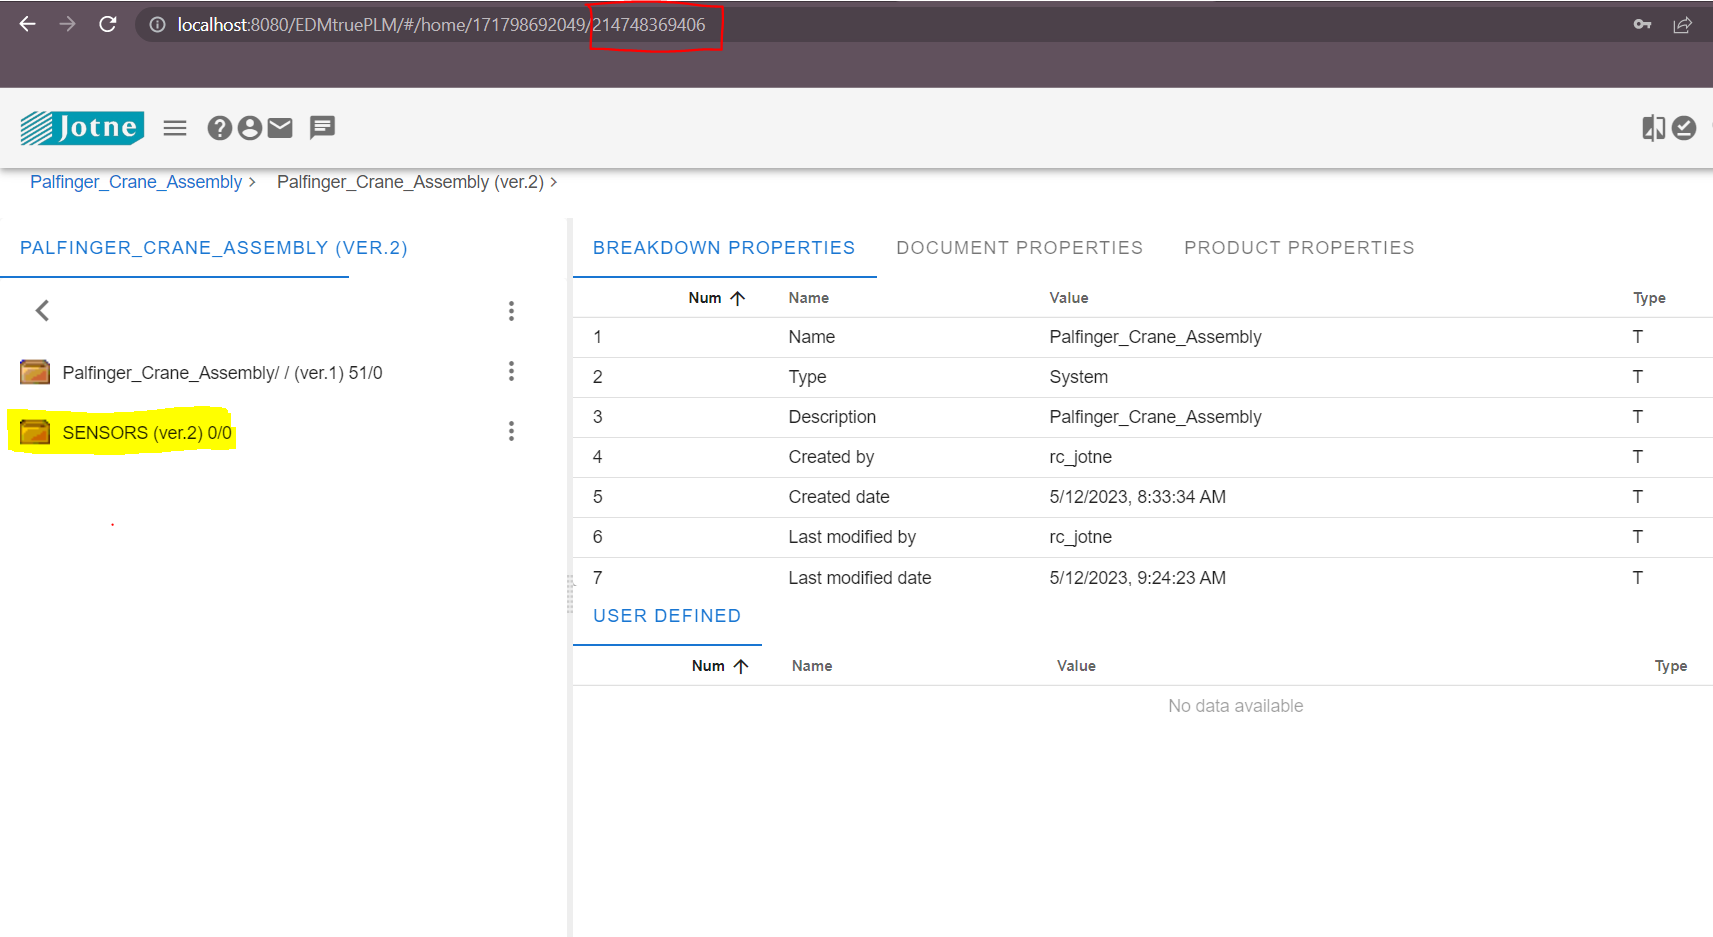

In [ ]:
#####################  Creating new BD element ###################### 

# Required input parameters

node= '214748369406'                                           # provide required instance id or node path 

model= 'Palfinger_Crane_Assembly'                              # Project name 

repository="TruePLMprojectsRep"                                # Project repo

data_param={'act_timestamp':'',                                # Current time stamp
           'descr':'stores sensors data',                      # Description of element  
           'name':'SENSORS',                                   # Required Breakdown element name
           'nodeType':'urn:rdl:epm-std:Unit',                  # Node type
           'tmpl':''}                                          # Name of the breakdown template


def create_new_bd_element(node,model,repository,data_param):

    token=get_token()

    create_new_bd_ele_url=PLM_URL+"/api/bkd/create"+"/"+repository + "/" + model + "/" + node + "/"+token

    print("\nPerforming request: " + create_new_bd_ele_url)

    try:
        response = requests.post(create_new_bd_ele_url,params=data_param,timeout=2.0)
        response.raise_for_status()
    except requests.exceptions.RequestException as e:  
        print('request failed due to ',response.text)
        return 
    if response.status_code!=200:
        print("\tRequest failed (error code = " + str(response.text) + ")")                                             
    else:
        pp.pprint(response.json())                              

create_new_bd_element(node,model,repository,data_param)   

####  6.API call for breakdown elements Quick Search

```
1.GET /api/bkd/q_search/{repository}/{model}/{token}, quick search for the breakdown element

2.GET /api/bkd/q_search_ext/{repository}/{model}/{token}, quick Search breakbown elements by string pattern with 
row number

The aforementioned methods are used to look for breakdown elements in a Project and find relevant properties. 

Based on the query parameters, the first function's output provides details on the required breakdown element's 
attributes.

Based on the query parameters, the second function's output returns information on the breakdown element's 
characteristics. Additionally, the JSON output response includes the following information: 

["page": 1, "page_size": 100, "total_rows"]

The total_rows displays the quantity of elements discovered using the specified query parameters.

The node option specifies the exact path in the tree to search for the required Breakdown element

```

In [ ]:
######################## q_search methods ######################

model= 'Palfinger_Crane_Assembly'           # Project name 

repository="TruePLMprojectsRep"             # Project repo

data_search_params={"case_sens":"false",    # Use case sensitive search or not
                    "domains":"ID",         # CSV list of subjects for search, can include ID, DESCRIPTION, CLASS, PROPERY
                    "folder_only":"true",   # Return only direct children of parent folder
                    "node":"",              # Breakdown element instance id - root of interesting branch
                    "page":"",              # Start page of output
                    "page_size":"",         # Page size of output
                    "pattern":"SENSORS",    # Search string pattern (for LIKE operations in EXPRESS)
                    "props":""}      # CSV list of property names where to apply search pattern (when PROPERTY is listed)


def bd_quick_search(search_type,data_params):
    
    token=get_token()
    
    
    if (search_type=="q_search"): # Quick search method 

        break_down_search_url = PLM_URL + "/api/bkd/q_search/" + repository + "/" + model + "/" + token

        print("\nPerforming request: " + break_down_search_url)
        
    elif (search_type=="q_search_ext"):  # Quick search_text method 
    
         break_down_search_url = PLM_URL + "/api/bkd/q_search_ext/" + repository + "/" + model + "/" + token

         print("\nPerforming request: " + break_down_search_url)
    else:
         print('invalid search')
    try:
        response = requests.get(break_down_search_url,params=data_params,timeout=2.0)
        response.raise_for_status()
    except requests.exceptions.RequestException as e: 
        print('request failed due to ',response.text)
        return 
    if response.status_code!=200:
        print("\tRequest failed (error code = " + str(response.text) + ")")       
    else:
        breakdown_search_result=response.json()
        pp.pprint(breakdown_search_result)                              
    return 

bd_quick_search('q_search_ext',data_search_params)


####  7.API call for breakdown element advanced search 

```
GET /api/bkd/a_search/{repository}/{model}/{token}, Advanced search for the breakdown element

This method is used to look for breakdown elements and obtain information about it. Based on the query parameters, the output of this function offers information on the attributes of the required breakdown element.

The nodeID parameter defines the precise route within the tree to find the needed Break down element. Otherwise, the response contains all Breakdown elements that satisfy the query criteria.
```

In [ ]:
#####################  BD search element ###################### 

# Inputs parameters

model= 'Palfinger_Crane_Assembly'      # Project name 

repository="TruePLMprojectsRep"        # Project repo

data_search_params={
                    "createAfter":'',  # Search for the breakdown element created after the specified date
                    "createBefore":'', # Search for the breakdown element created before the specified date
                    "createUser":'',   # Search value for the breakdown element creator person
                    "descr":'',        # Search pattern for the breakdown element description
                    "editAfter":'',    # Search for the breakdown element edited after the specified date
                    "editBefore":'',   # Search for the breakdown element edited before the specified date
                    "editUser":'',     # Search value for the breakdown element editor person
                    "limit":'',        # Limit for the number of search result 
                    "nodeID":'',       # Root element’s instance ID of the branch to search within
                    "nodeVer":'',      # Version number of the element to search within
                    "pPhase":'',       # Project phase to search within
                    "pattern":"SENSORS",    # Search pattern for the breakdown element name
                    "propName":[],          # List of the breakdown element property names to search for
                    "propVal":[],           # List of the breakdown element property values to search for
                    "type":''}              # Search pattern for the breakdown element type (urn:rdl:epm-std:Unit)


def bd_advanced_search(data_search_params):

    token=get_token()

    break_down_search_url = PLM_URL + "/api/bkd/a_search/" + repository + "/" + model + "/" + token

    print("\nPerforming request: " + break_down_search_url)

    try:
        response = requests.get(break_down_search_url,params=data_search_params,timeout=2.0)
        response.raise_for_status()
    except requests.exceptions.RequestException as e: 
        print('request failed due to ',response.text)
        return 
    if response.status_code!=200:
        print("\tRequest failed (error code = " + str(response.text) + ")")  
    else:
        breakdown_search_result=response.json()
        return breakdown_search_result
                                 
response=bd_advanced_search(data_search_params)
pp.pprint(response)   


####  8.API call for deleting breakdown element

```
Delete /api/dat/{repository}/{model}/{doc}/{token}    
This method is used for deleting breakdown element in a project. 
In the below image the user want to delete the 'SENSORS 2' breakdown element.
```
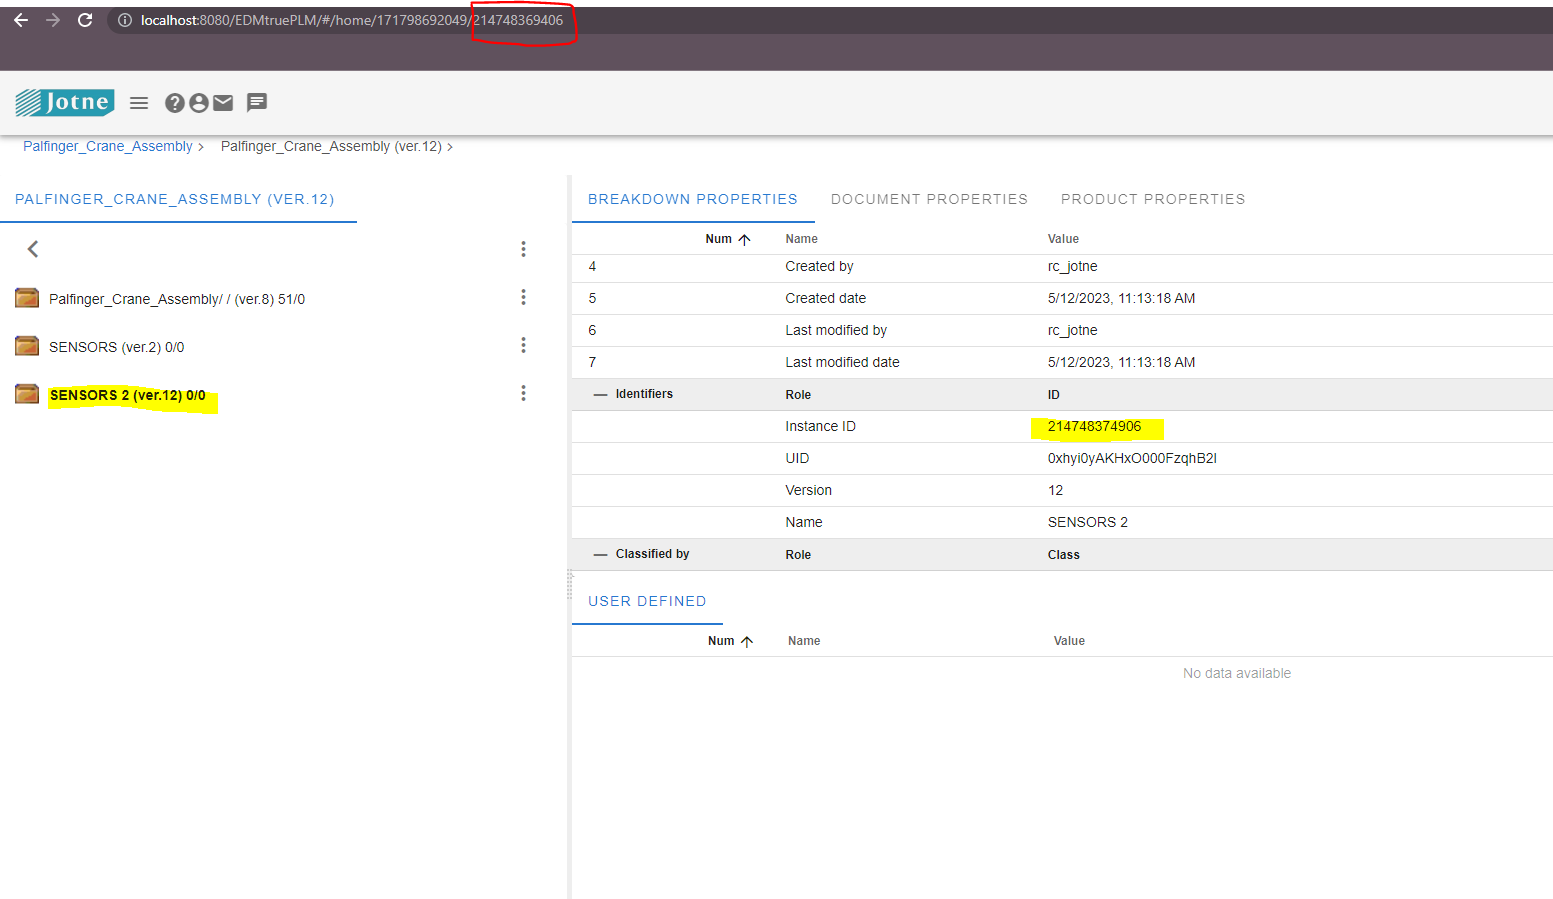

In [ ]:
#####################  Deleting Break down element ###################### 

# Input parameters  

model= 'Palfinger_Crane_Assembly'           # Project name 

repository="TruePLMprojectsRep"             # Project repo

node="21478374906"                          # Instance id of the required breakdown element to delete

def delete_breakdown_element(node):

    token=get_token()

    del_bd_elem_url=PLM_URL+"/api/bkd"+"/"+repository + "/" + model + "/" + node + "/"+token

    print("\nPerforming request: " + del_bd_elem_url)

    try:
        response = requests.delete(del_bd_elem_url,timeout=2.0)
        response.raise_for_status()
    except requests.exceptions.RequestException as e: 
        print('request failed due to ',response.text)
        return 
    if response.status_code!=200:
        print("\tRequest failed (error code = " + str(response.text) + ")")  
    else:
        pp.pprint(response.json())     
        
delete_breakdown_element(node)

#### 9.API call for updating user defined  properties of a breakdown element 

```
POST /api/bkd/prop/{repository}/{model}/{node}/{token}
This method is used for updating the Breakdown element user defined properties values. 
Before that these properties need to be defined in Reference data values in EDMtruePLM by the user.

```
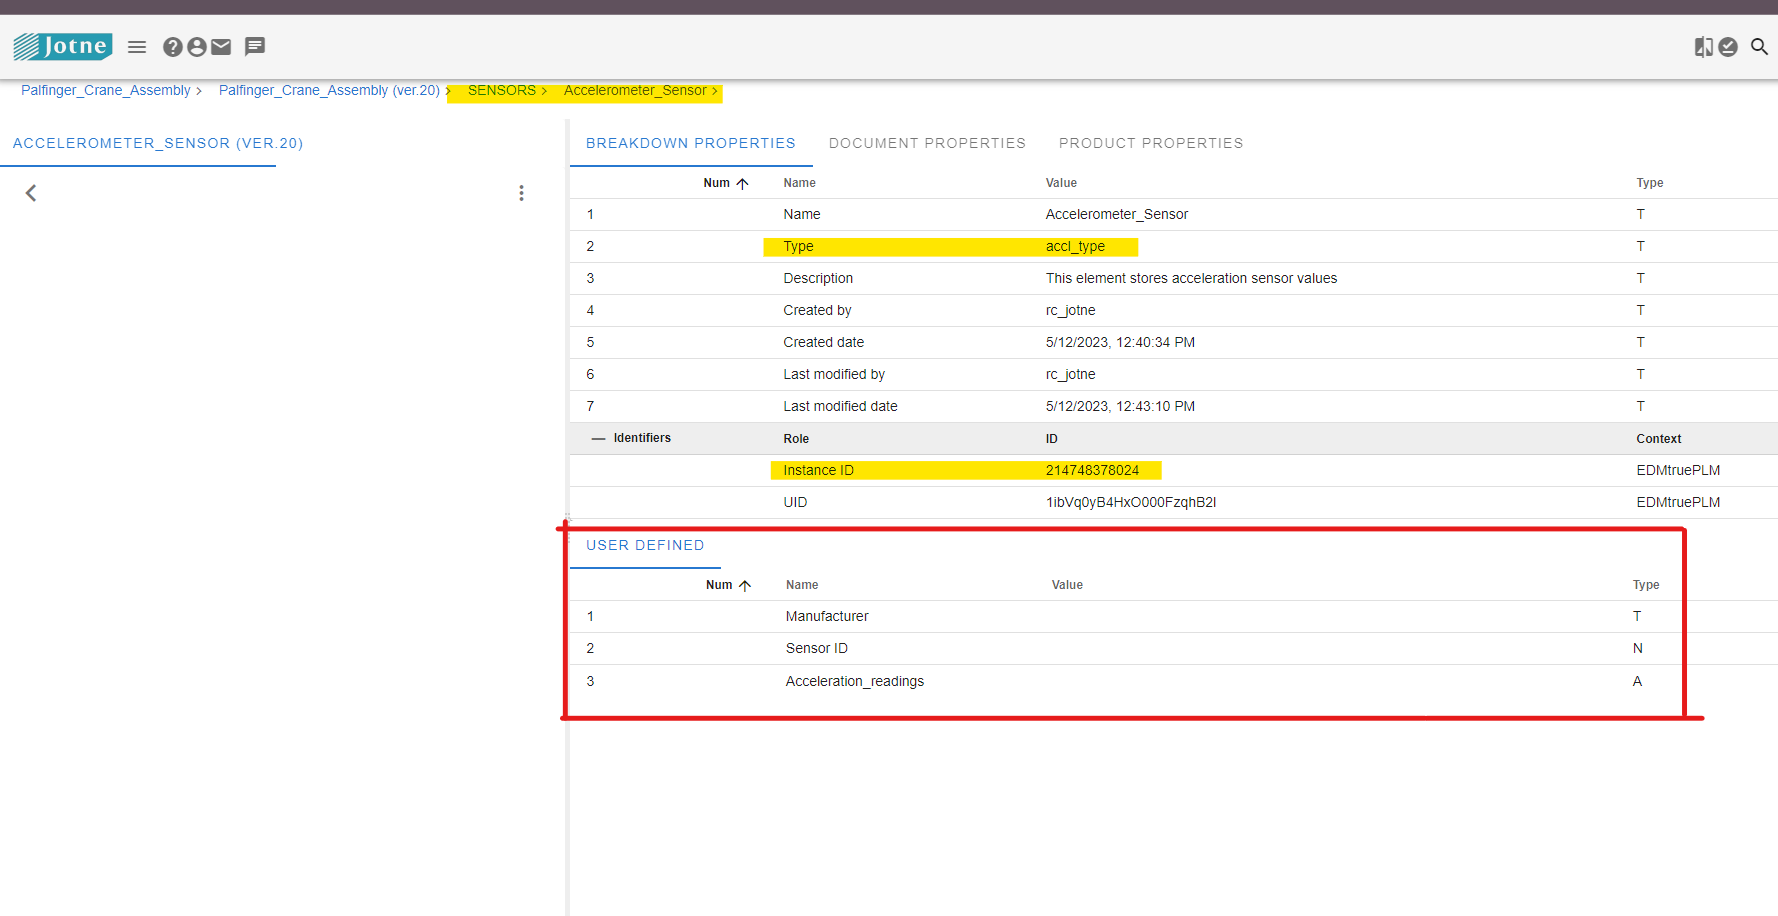

In [ ]:
#####################  Updating breakdown element Property information  ###################### 

node="450971570824"                   # Required breakdown element instance id 

model= 'Palfinger_Crane_Assembly'     # Project name 

repository="TruePLMprojectsRep"       # Project repo

# Breakdown element properties

Upload_prop_data={
     'act_timestamp':'',
     'props': ["urn:rdl:Palfinger_Crane_Assembly:Manufacturer","urn:rdl:Palfinger_Crane_Assembly:Sensor ID","urn:rdl:Palfinger_Crane_Assembly:part"],
     'ptypes': ['string','N','string'],
     'units':["","",""],
     'vals': ['ABC',10001,'-']}

def update_breakdown_element_prop(node,Upload_prop_data):

    token=get_token()

    update_prop_url = PLM_URL + "/api/bkd/prop/" + repository + "/" + model + "/" + node + "/"  + token
    print("\nPerforming request: " + update_prop_url)

    try:
        response = requests.post(update_prop_url,data = Upload_prop_data, timeout=2.0)
        response.raise_for_status()
    except requests.exceptions.RequestException as e:  
        print('request failed due to ',response.text)
        return
    print("status_code: ", response.status_code)
    if response.status_code!=200:
        print("\tRequest failed (error code = " + str(response.text) + ")")  
    else:
        update_info=response.json()                       
        print("\ndata uploaded :",update_info)
        return 
        
update_breakdown_element_prop(node,Upload_prop_data)

In [ ]:
# The quick search method can be used to obtain information on the user defined breakdown properties.

# The JSON response return from the quick search function is displayed below, and the response 'properties' comprises an array of user-defined breakdown properties and their values.

# [{'bkdn_elem_info': {'children': None,
#                      'children_count': 0,
#                      'children_loaded': False,
#                      'classified_as': None,
#                      'created_by_user': 'rc_jotne',
#                      'data_contents': None,
#                      'date_created': '2023-05-12 10:40:34',
#                      'date_last_modified': '2023-05-12 10:55:29',
#                      'datetimes': None,
#                      'described_as': None,
#                      'description': 'This element stores acceleration sensor '
#                                     'values',
#                      'element_type': 'urn:rdl:Palfinger_Crane_Assembly:accl_type',
#                      'has_child_occurrences': None,
#                      'has_occurrences': None,
#                      'has_shape_elements': None,
#                      'id': '1ibVq0yB4HxO000FzqhB2l',
#                      'ids': None,
#                      'instance_id': 214748378024,
#                      'is_part': False,
#                      'is_part_of_subdomain': 0,
#                      'is_requirement': False,
#                      'is_root_of_subdomain': 0,
#                      'last_modified_by_user': 'rc_jotne',
#                      'local_occurrence': None,
#                      'name': 'Accelerometer_Sensor',
#                      'occurrence': None,
#                      'occurrence_users': None,
#                      'orgs': None,
#                      'parents': None,
#                      'permissions': None,
#                      'persons': None,
#                      'phase': 'urn:rdl:epm-std:0',
#                      'properties': [{'action': None,
#                                      'is_derived': False,
#                                      'name': 'urn:rdl:Palfinger_Crane_Assembly:Manufacturer',
#                                      'num_val': 0.0,
#                                      'si_unit': False,
#                                      'unit': None,
#                                      'val': 'ABC',
#                                      'value_domain': 'urn:plcs:rdl:TruePLM:Text_value'},
#                                     {'action': None,
#                                      'is_derived': False,
#                                      'name': 'urn:rdl:Palfinger_Crane_Assembly:Sensor '
#                                              'ID',
#                                      'num_val': 10001.0,
#                                      'si_unit': False,
#                                      'unit': None,
#                                      'val': '10001.000000',
#                                      'value_domain': 'urn:plcs:rdl:TruePLM:Numeric_value'}],
#                      'quantity': '1.000000',
#                      'rels': None,
#                      'subdomains': None,
#                      'templates': None,
#                      'version_id': '22'},
#   'path': ['Palfinger_Crane_Assembly', 'SENSORS', 'Accelerometer_Sensor'],
#   'tree_path_to_element': [214748369406, 214748374051, 214748378024]}]


# The instance_Id of the Breakdown element is : 214748378024

#### 10.API call for uploading Aggregate data to a breakdown element

```
The user needs to define the aggregate properties for the breakdown element. 

If the key field is set to DATE format while defining aggregate, then the user can specify 
the format of the date and time as shown in Figure date format. 
This format is required when uploading the data.

Furthermore, from the version 3.6 to filter the data using DATE format user need to use the UNIX millisecond 
format (1686029024000).

1. POST /api/bkd/aggr_json/{repository}/{model}/{node}/{prop}/{token}  upload data in JSON format
2. POST /api/bkd/aggr_csv/{repository}/{model}/{node}/{prop}/{token} in upload data in CSV format 
```

In [ ]:
# The example for a JList of JSON format data for uploading is shown below 
#and the aggregate properties are created for the element in EDMtruePLM to store 
#accelerometer sensor values and it contains timestamp, acceleration in x,y,z directions

# [{"Timestamp": "2023-04-18 09:30:03", "X": 14, "Y": -2, "Z": 9},
#  {"Timestamp": "2023-04-18 09:30:04", "X": -4, "Y": -5, "Z": -3},
#  {"Timestamp": "2023-04-18 09:30:05", "X": 12, "Y": 0, "Z": -2},
#  {"Timestamp": "2023-04-18 09:30:06", "X": 13, "Y": 0, "Z": 9},
#  {"Timestamp": "2023-04-18 09:30:07", "X": 0, "Y": -9, "Z": 5}]

# The example for uploading data in a CSV format data is shown below 

# Timestamp,X,Y,Z
# 2023-04-10 15:30:18,-2,-7,7
# 2023-04-10 15:30:19,8,7,-7


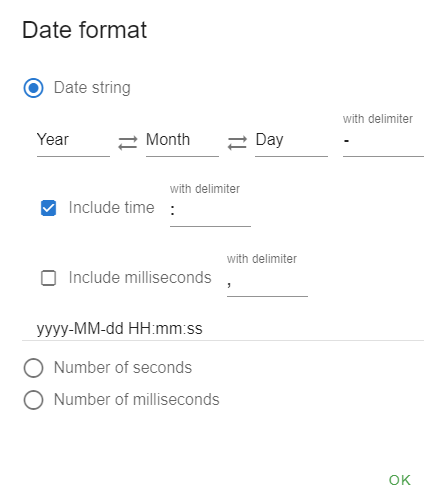

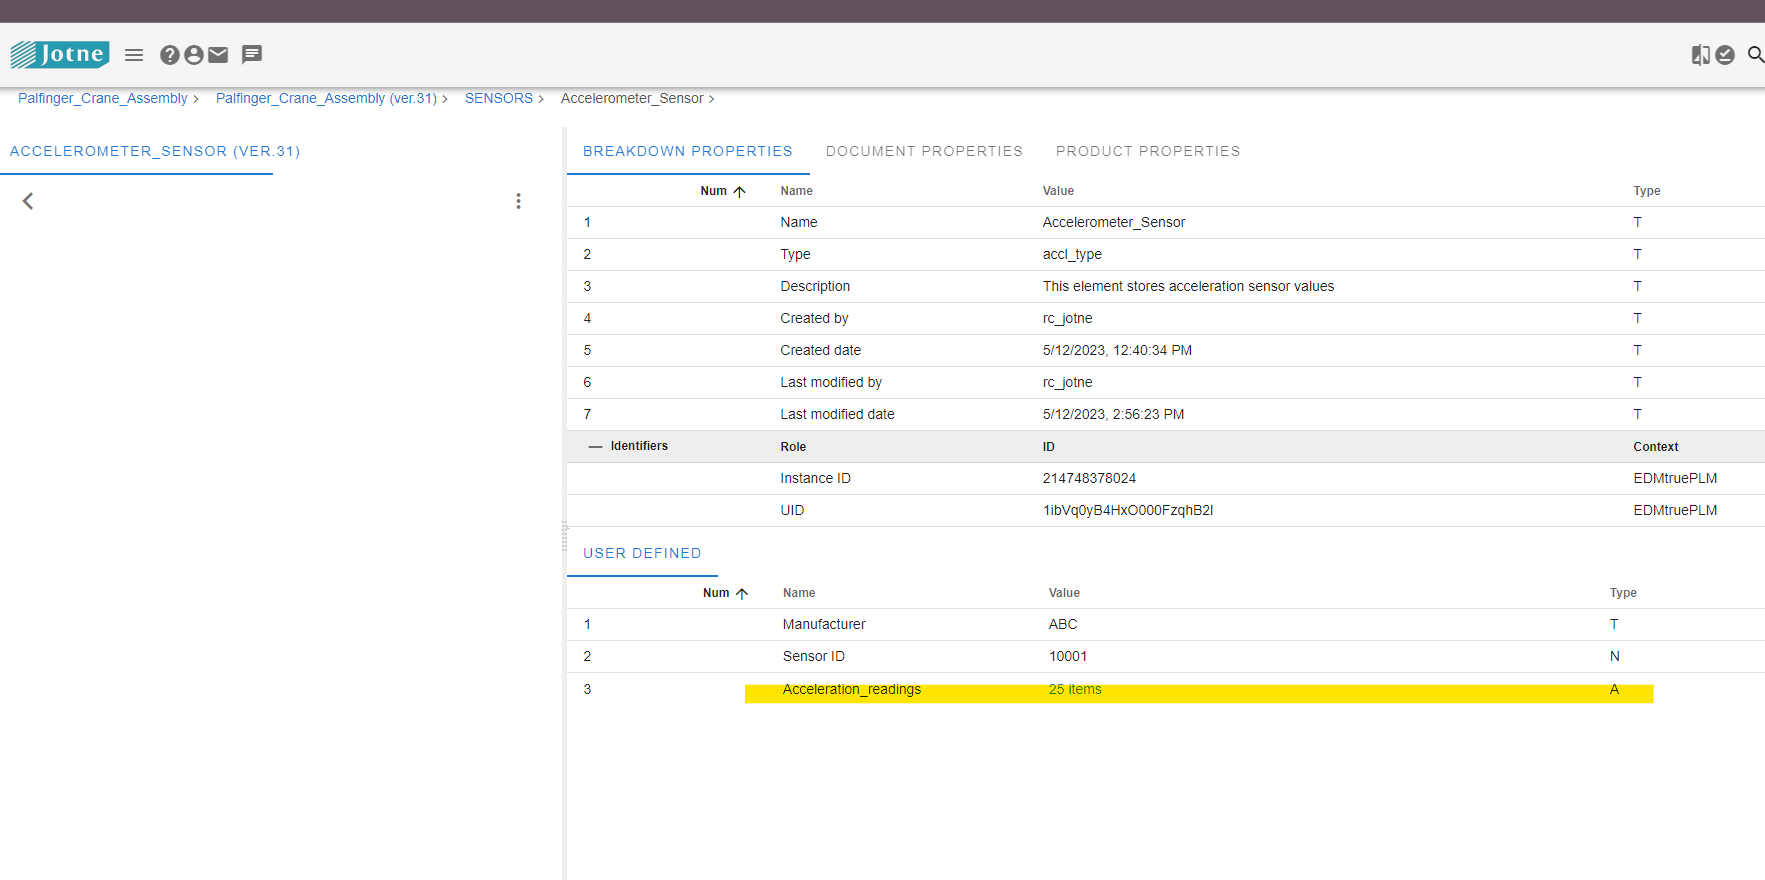

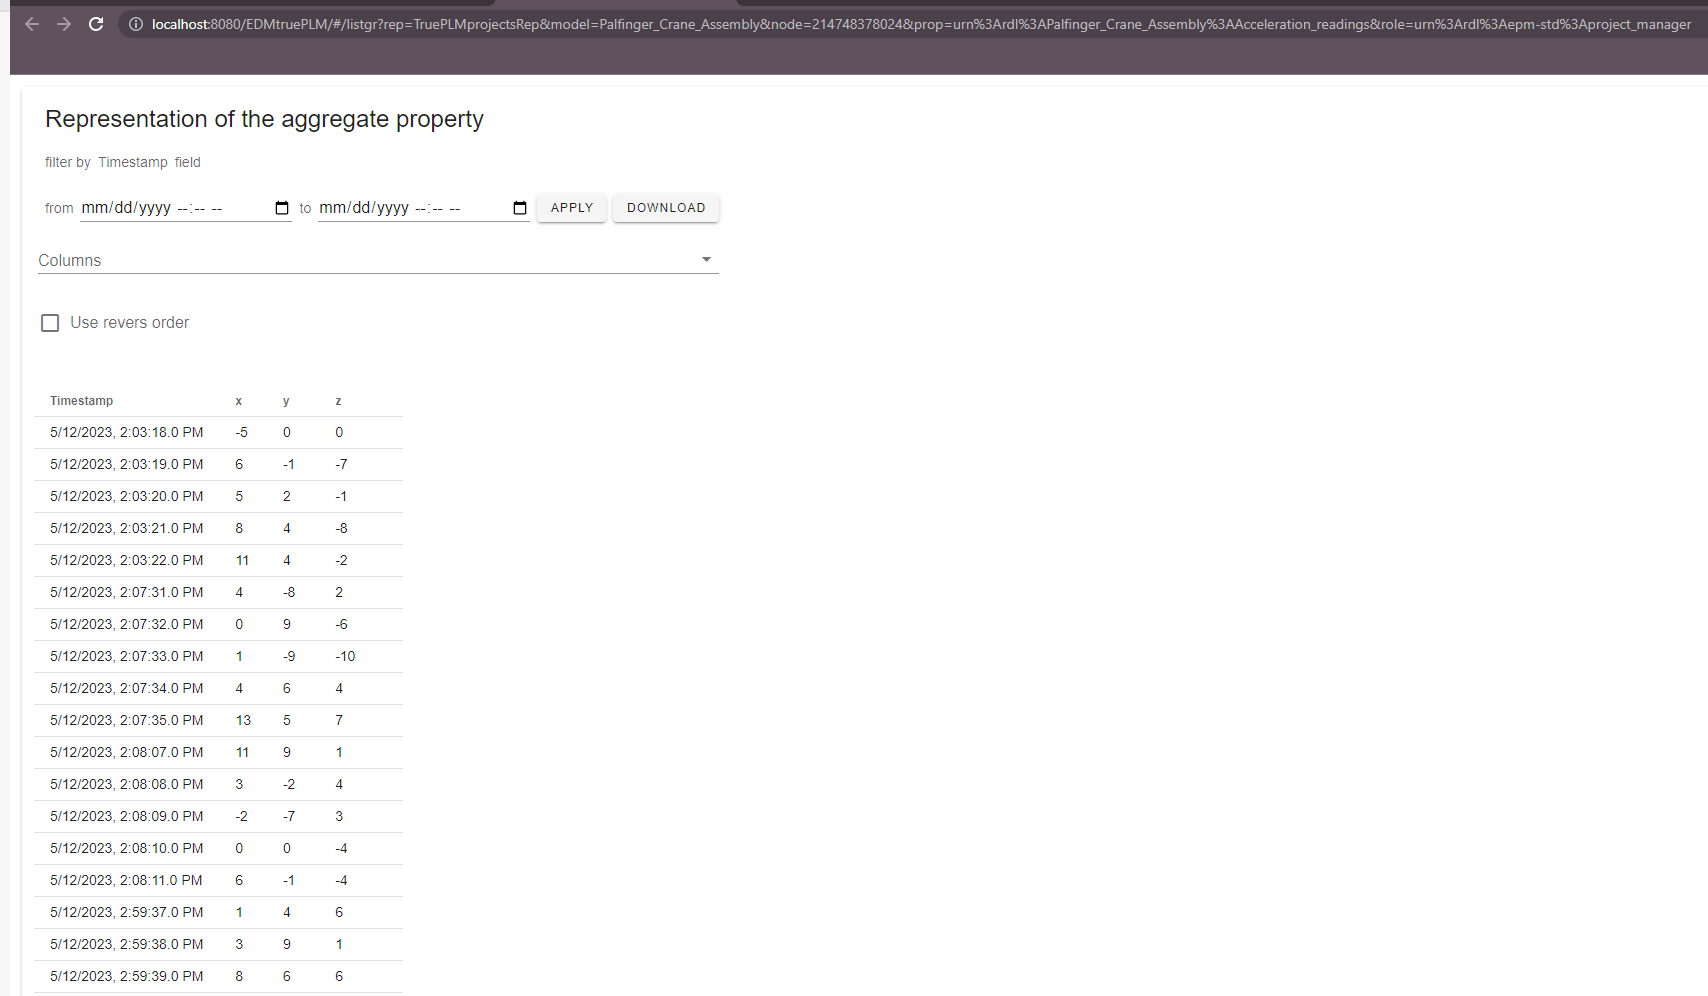

In [ ]:
#####################  Uploading aggr data  ###################### 

# Generating random data for uploading 
def generating_sample_data(no_of_records):
    
    currentx=0
    currenty=0
    currentz=0
    currentTimeStamp = 0
    data_accl = []
    
    for _ in range(no_of_records):
       
        time.sleep(1)
        
        currentTimeStamp = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        
        currentx = (random.randrange(-5, 15))
        
        currenty =(random.randrange(-10,10))
        
        currentz = (random.randrange(-10,10))
    
        data_accl.append({"Timestamp" : currentTimeStamp, "X" : currentx, "Y" : currenty,"Z" : currentz })  
        
    # Writing data to JSON file  
    
    file = open("accl_new_file.json", "w")
    file.write(json.dumps(data_accl))
    file.close()
    print("\t data written to " + "accl_new_file.json")
    
    # Writing data to CVS file  
    
    file = open("accl_new_file.json", "r")
    df_csv = pd.read_json(file)
    df_csv.to_csv("accl_new_file.csv",index=False)
    file.close()
    
    return 

# API methods to upload data 

def upload_data(file_path,url_type,model,node,prop,repository="TruePLMprojectsRep"):
    
    if (url_type=='JSON'):       # URL for uplaoding JSON data 
        token=get_token()
        url_json = PLM_URL + "/api/bkd/aggr/" + repository + "/" + model + "/" + node + "/" + prop + "/" + token
        ADD_TO_AGGR_URL_format=url_json 
        
    elif (url_type=='CSV'):     # URL for uplaoding CSV data 
        token=get_token()
        url_csv = PLM_URL + "/api/bkd/aggr_csv/" + repository + "/" + model + "/" + node + "/" + prop + "/" + token
        ADD_TO_AGGR_URL_format=url_csv
        
    print("\nPerforming request: " + ADD_TO_AGGR_URL_format)
    file=open(file_path, "r")
    try:
        response = requests.post(ADD_TO_AGGR_URL_format, files = {"file" : file }, timeout=2.0)
        response.raise_for_status()
    except requests.exceptions.RequestException as e:  # This is the correct syntax
        print('request failed due to:',response.text)
        return 
    if response.status_code!=200:
        print("\tRequest failed (error code = " + str(response.text) + ")")
    else:
        print("\tRequest (status code = " + str(response.status_code) + ")")
        print("file uploaded sucessfully ")    
    file.close()    
    
    return 


# Input parameters 

no_of_records=10                                      # required no of records to upload 

generating_sample_data(no_of_records)

node="214748378024"                                  # Breakdown element instance id

repository="TruePLMprojectsRep"       # Project repo

model="Palfinger_Crane_Assembly"                     # porject name

prop = "urn:rdl:" + model + ":Acceleration_readings"  # porperty

upload_data("accl_new_file.json",'JSON',model,node,prop)

#### 11.API call to Export aggregate data from breakdown elements (Method 1)

```
To download aggregate data the following API calls are required:

1./api/bkd/aggr_exp/{repository}/{model}/{node}/{prop}/{token}, Export the values of the aggregated property with paging and filtering to the JSON format

2. /api/dat/file/data/{src}/{name}/{token}, Return file data for download

The first method takes inputs parameters to get data in required format either CSV or JSON . This method will generate 
file properties as shown in below example.

    {'descr': None,
    'source': 'aggr6673349257703198929down',
    'contentType': None, 
    'discipline': None, 
    'projPhase': None, 
    'status': None, 
    'editor': None, 
    'resp': None, 
    'rev': None, 
    'app': None, 
    'revMan': None, 
    'title': 'Accleration_readings_data.csv',
    'isNewIssue': False}

The source and title values are supplied to the second API function from this response.

The example for output response in csv format is shown below 

Timestamp,X,Y,Z

2023-04-11 06:31:04,0,-6,-9
2023-04-11 06:31:05,12,-4,8
2023-04-11 06:31:06,9,7,-9

The example for output resposne in JSON  format is shown below 

[{"Timestamp":"2023-04-11 06:31:04","X":"0","Y":"-6","Z":"-9"},
{"Timestamp":"2023-04-11 06:31:05","X":"12","Y":"-4","Z":"8"},
{"Timestamp":"2023-04-11 06:31:06","X":"9","Y":"7","Z":"-9"}]

```
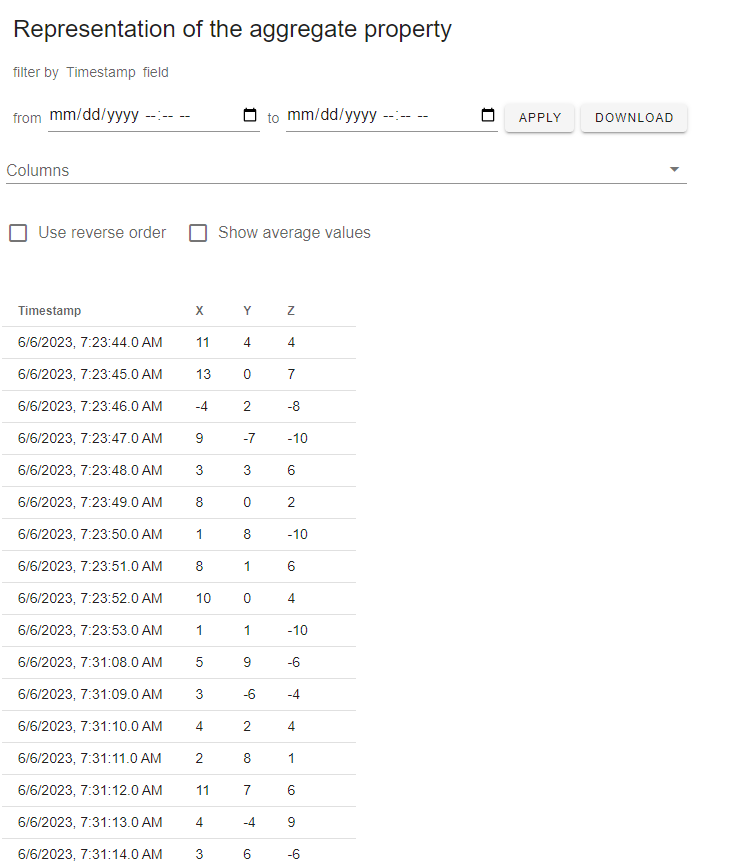

In [ ]:
#####################  downloading aggr data  ###################### 

#################### parameters required #############
 
node="214748378024"                                   # Breakdown element instance id

model="Palfinger_Crane_Assembly"                      # porject name

prop = "urn:rdl:" + model + ":Acceleration_readings"  # porperty

repository="TruePLMprojectsRep"


data_params={'from':"1686029024000",  # date format for should be unix format with milliseconds(example:1686029024000)
            'to':"1686029476000",
            'format':'json',          # csv or json
            'cols':[]}                # Example to select required cols ['x','z']


def get_data_prop(data_params):
    
    token=get_token()
    
    download_data_file_prop = PLM_URL + "/api/bkd/aggr_exp/" + repository + "/" + model + "/" + node + "/" + prop + "/" + token

    print("\nPerforming request:", download_data_file_prop)
    try:
        response = requests.get( download_data_file_prop,params=data_params, timeout=2.0)
        response.raise_for_status()
    except requests.exceptions.RequestException as e: 
        print('request failed due to ',response.text)
        return
    if response.status_code!=200:
        print("\tRequest failed (error code = " + str(response.text) + ")")
    else:
        print("\tRequest (status code = " + str(response.status_code) + ")")
        file_prop=response.json()
        return file_prop   
        
def download_data(file_prop):        

    token=get_token()
    
    download_data_url = PLM_URL+"/api/dat/file/data/"+file_prop['source']+"/"+file_prop['title']+"/"+token

    print("\nPerforming request:",download_data_url)

    try:
        response = requests.get(download_data_url, timeout=2.0)
    except requests.exceptions.RequestException as e:  
        print('request failed due to ',response.text)
        pass
    if response.status_code!=200:
        print("\tRequest failed (error code = " + str(response.text) + ")")
    else:
        print("\tRequest (status code = " + str(response.status_code) + ")")
        return response
              
data_response=download_data(get_data_prop(data_params)).text 
print(data_response)

#### 12.API call to Export aggregate data from Breakdown elements (Alternate method 2)

```
To download aggregate data the following API is required. which returns the records in a array of values.

GET /api/bkd/aggr/{repository}/{model}/{node}/{prop}/{token} Return the values of the aggregated property 
with paging and filtering.

This method returns the records in reverse order if-required. 
```

In [ ]:
#################### parameters required #############

node="214748378024"                                   # Breakdown element instance id
model="Palfinger_Crane_Assembly"                      # porject name
repository="TruePLMprojectsRep"                       # Project repo
prop = "urn:rdl:" + model + ":Acceleration_readings"  # porperty

repository="TruePLMprojectsRep"

data_params={'from':"",             # date format should be unix with milliseconds(example:1686029024000)
            'to':"",                # date format should be unix with milliseconds(example:1686029024000)
            'format':'',            # csv or json
            'page':'',              
            'size':'',
            'reverse_order':''}     # Use reverse order of the records                    


def get_data_aggr(model,node,prop,data_params,repository):
    
    token=get_token()
    
    download_aggr_data = PLM_URL + "/api/bkd/aggr/" + repository + "/" + model + "/" + node +\
    "/" + prop + "/" + token

    print("\nPerforming request:", download_aggr_data)
    try:
        response = requests.get(download_aggr_data,params=data_params, timeout=2.0)
        response.raise_for_status()
    except requests.exceptions.RequestException as e:  
        print('request failed due to ',response.text)
        return
    if response.status_code!=200:
        print("\tRequest failed (error code = " + str(response.text) + ")")
    else:
        return response.json()
    
    
data=get_data_aggr(model,node,prop,data_params,repository) 
pp.pprint(data)

#### 13.API call to Export aggregate data in Breakdown elements (Alternate method 3)

```
This method is available from PLM version 3.5 and this gives us the data export options in either CSV or JSON format and reduces the  need for using multiple API methods to export data.

/api/bkd/aggr_exp_dt/{repository}/{model}/{node}/{prop}/{token} Export the values of the aggregated property with paging and filtering to the JSON format
```


In [ ]:
#####################  downloading sensor data  ###################### 
token=get_token()

node="214748378024"                                   # Instance id

model="Palfinger_Crane_Assembly"                      # project name

prop = "urn:rdl:" + model + ":Acceleration_readings"  # porperty

data_params={'from':"1686029024000",             # date format should be unix with milliseconds(example:1686029024000)
            'to':"1686029476000",
            'format':'json',                     # csv or json
            'cols':['X','Z']}                    # cols ['x','z']

def download_aggr_data(data_params):
                     
    get_filtered_data_url =PLM_URL+ "/api/bkd/aggr_exp_dt/" + repository + "/" + model + "/" + node + \
                                                                                          "/" + prop + "/"+token

    print("\nPerforming request:",get_filtered_data_url)

    try:
        response = requests.get(get_filtered_data_url, params=data_params,timeout=2.0)
    except requests.exceptions.RequestException as e:  # This is the correct syntax
        print("ERROR: request.post failed.")
        pass

    if response.status_code!=200:
        print("\tRequest failed (error code = " + str(response.text) + ")")
    else:
        print("\tRequest (status code = " + str(response.status_code) + ")")
        get_filtered_data_param=response.text
        print(get_filtered_data_param)
        
download_aggr_data(data_params)


#### 14.API call for Uploading a file to break down element

```
The method is used for uploading a file to a breakdown element /api/dat/{repository}/{model}/{node}/{token} 

This method can be used to upload any file like (excel, pdf, word, images).

In the below figure the user has uploaded a file in Maintenance data breakdown element 
```
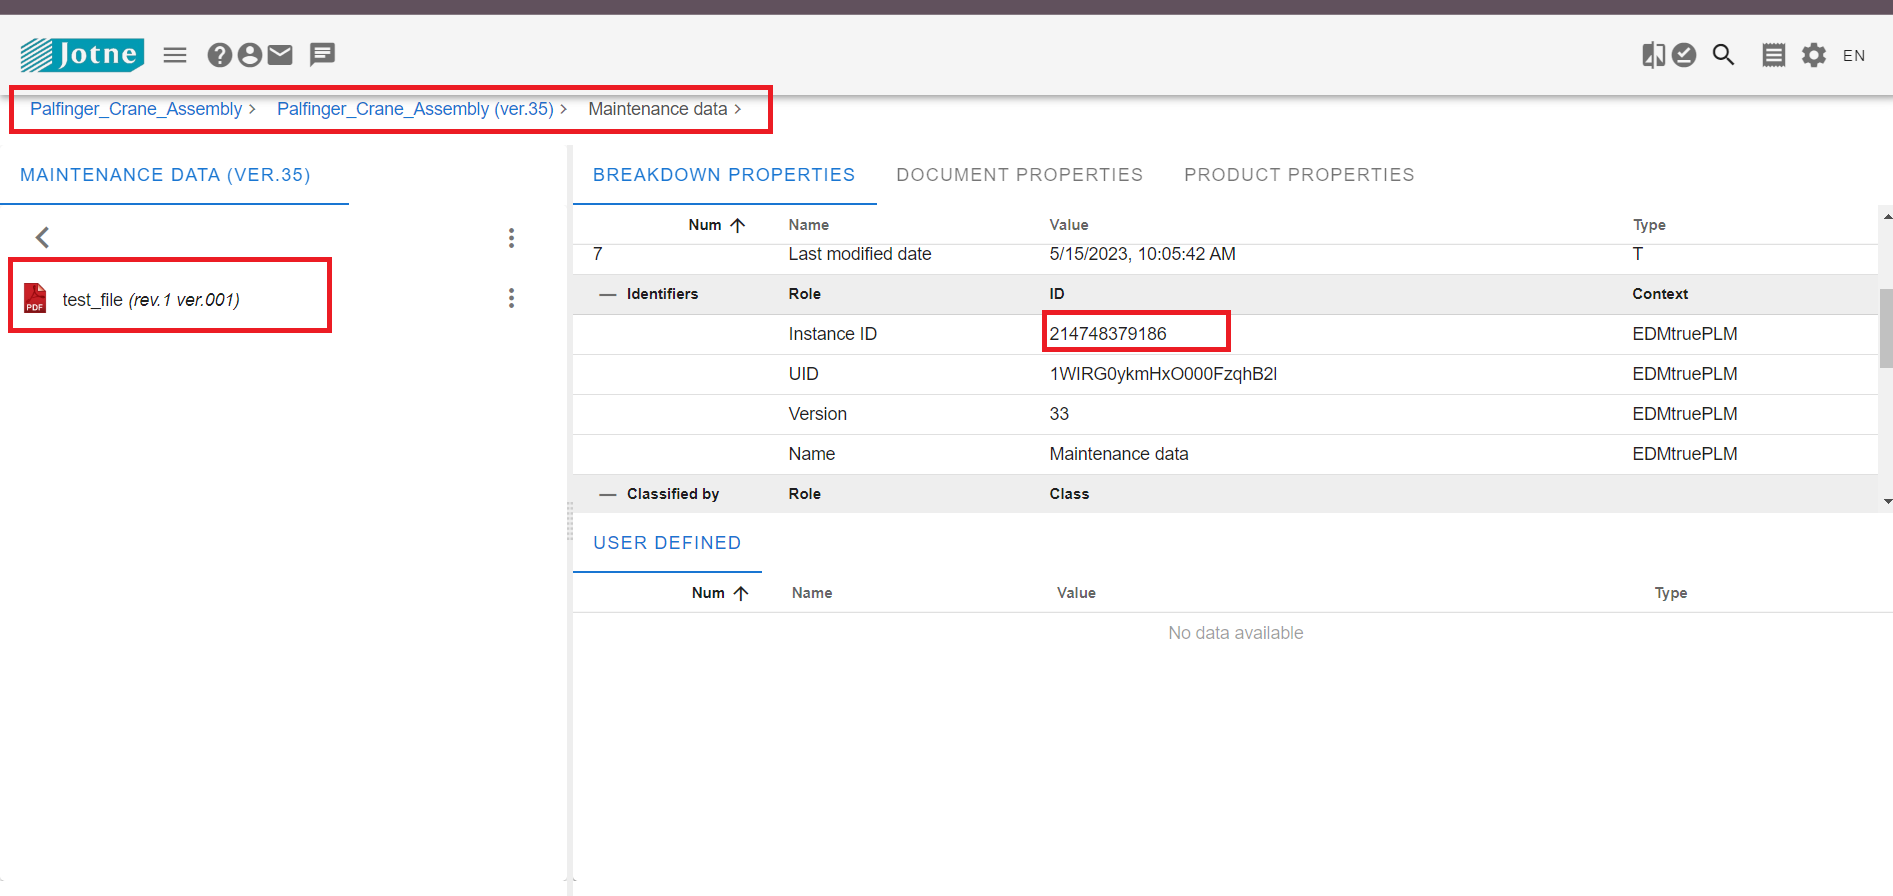

In [ ]:
def upload_file(data_param,file_to_upload,model,node,repository):
    
    token=get_token() 

    url_upload_file=PLM_URL+"/api/dat"+"/"+repository + "/" + model + "/" + node + "/"+token

    print("\nPerforming request: " + url_upload_file)

    try:
        response = requests.post(url_upload_file,files= {"file" : file_to_upload },data=data_param,timeout=5.0)
        response.raise_for_status()
    except requests.exceptions.RequestException as e: 
        print('request failed due to ',response.text)
        return

    if response.status_code!=200:
        print("\tRequest failed (error code = " + str(response.text) + ")")
    else:
        print("\tRequest (status code = " + str(response.status_code) + ")")  
        pp.pprint(response.json())
        
# Input Parameters required for file upload 

file_path = "test_file.pdf"                                 # file path to upload 
file_to_upload = open(file_path, "rb") 
data_param={'descr':"maintenance information",              # Description of the document
           'title':"test_file",                             # Title of the document
           'source':"urn:rdl:epm-std:Unknown",              # Source of the document
           'contentType':'urn:rdl:epm-std:Miscellaneous',   # Content type of the document
           'discipline':'urn:rdl:epm-std:Uncertain',        # Discipline of the document
           'projPhase':'urn:rdl:epm-std:0',                 # Project phase of the document
           'status':'urn:rdl:epm-std:Approved',             # Status of the document
           'editor':'jotne_rc',                             # Login of person, who edited the document
           'resp':'jotne_rc',                               # Login of person, who responsible for the document
           'rev':'jotne_rc',                                # Login of person, who reviewed the document
           'app':'jotne_rc',                                # Login of person, who approved the document
           'revMan':'jotne_rc'}                             # Login of person, who is the release manager for the document

node="450971600356"      # break_down element instance id where the file need to be uploaded ( Maintenance data element)

model="Palfinger_Crane_Assembly"     # Project name
repository="TruePLMprojectsRep"      # project repository  

upload_file(data_param,file_to_upload,model,node,repository)


#### 15.API call for documents quick search method 

```
This method is used for searching documents in a project.

/api/dat/q_search/{repository}/{model}/{token} quick Search for the documents
```
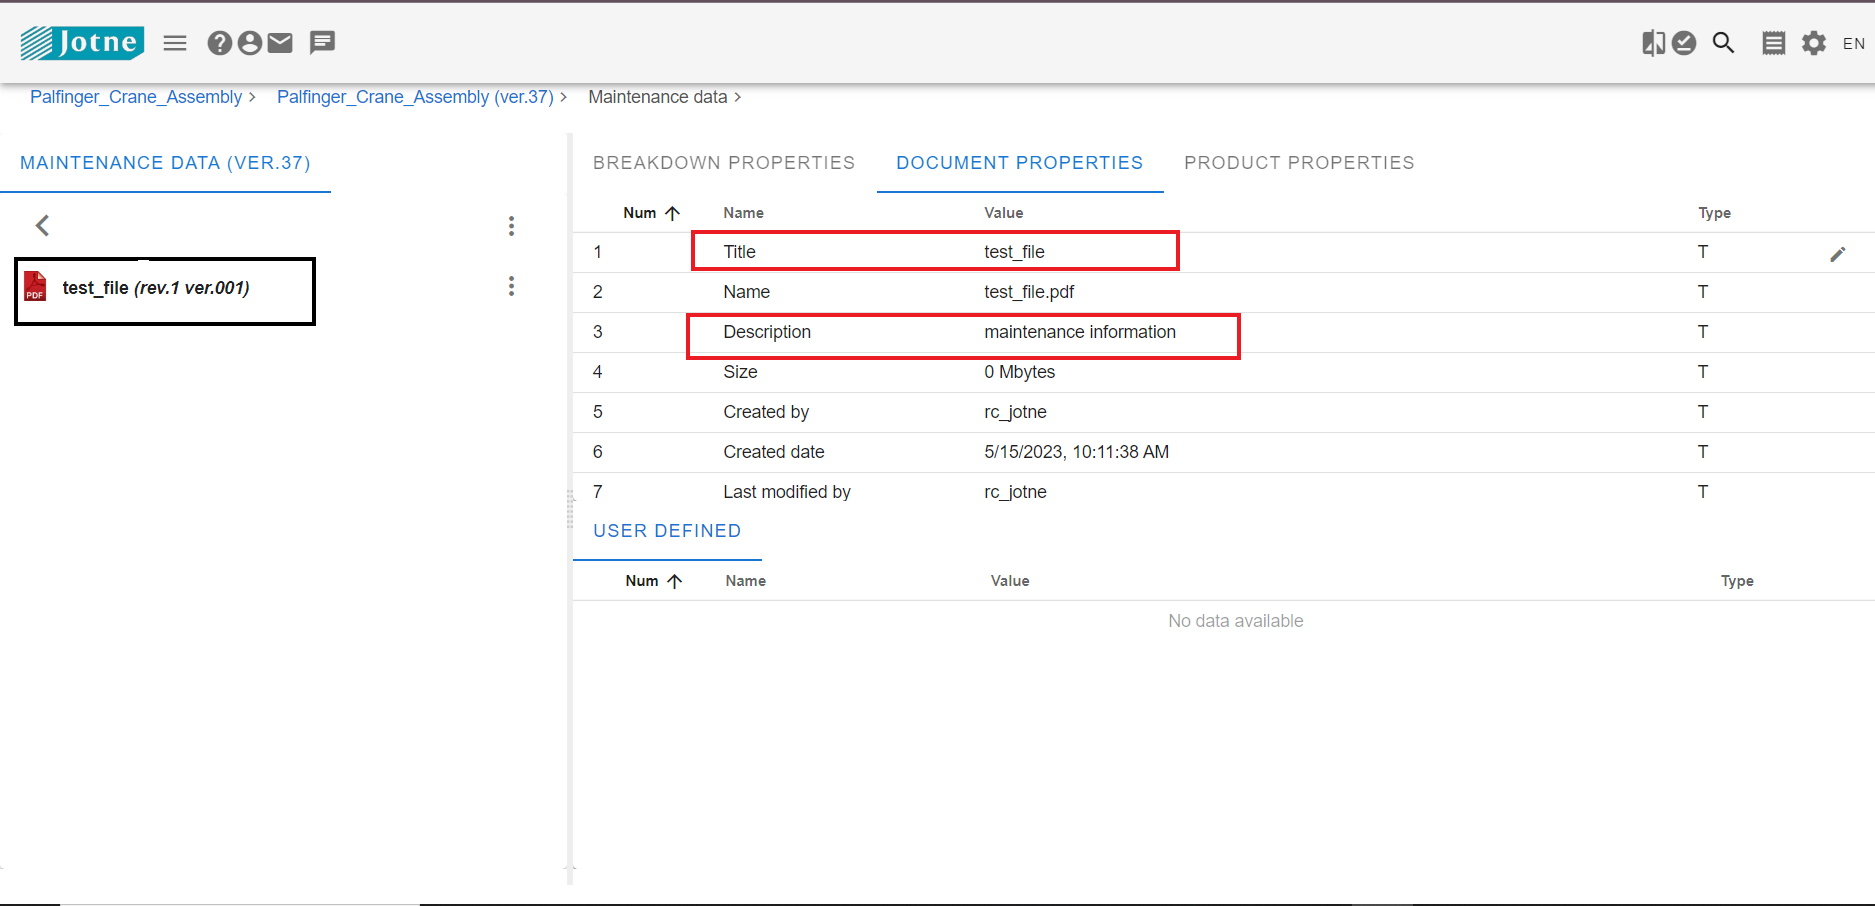

In [ ]:
# parameters required for document quick search method 

data_param={'case_sens':'no',    # Use case sensitive search or not
            'domains':'ID',      # CSV list of subjects for search, can include ID, DESCRIPTION, CLASS, PROPERTY
            'node':'',           # Breakdown element instance id - root of interesting branch
            'page':'',           # Start page of output
            'page_size':'',      # Page size of output
            'pattern':'test_file', # Search string pattern (for LIKE operations in EXPRESS)
            'props':''}            # CSV list of property names where to apply search pattern 


def doc_quick_search(data_param):
    
    token=get_token()
    model="Palfinger_Crane_Assembly" 

    doc_search_url=PLM_URL+"/api/dat/q_search"+"/"+repository + "/" + model + "/"+token
    print("\nPerforming request: " + doc_search_url)

    try:
        response = requests.get(doc_search_url,params=data_param,timeout=2.0)
        response.raise_for_status()
    except requests.exceptions.RequestException as e:  
        print('request failed due to ',response.text)
        return

    if response.status_code!=200:
        print("\tRequest failed (error code = " + str(response.text) + ")")
    else:
        print("\tRequest (status code = " + str(response.status_code) + ")")  
        pp.pprint(response.json())
        
doc_quick_search(data_param)


#### 16.API call for document advance search method

``` 
This method is used for searching documents in a project.

/api/dat/a_search/{repository}/{model}/{token} Advanced search for the documents 
```

In [ ]:
# parameters required for doduemnt search 

data_param={ 'approver':'',         # Search value for the document approver person
            'checkOutUser':'',      # Search for the documents checked out by the specified person
            'createAfter':'',       # Search for the document created after the specified date
            'createBefore':'',      # Search for the document created before the specified date
            'createUser':'',        # Search for the documents created by the specified person
            'dataType':'',          # Search value for the document data type
            'descipline':'',        # Search value for the document discipline
            'descr':'maintenance information',             # Search pattern for the document description
            'docSource':'',         # Search value for the document source
            'docStatus':'',         # Search value for the document status
            'docType':'',           # Search value for the document type
            'editAfter':'',         # Search for the document edited after the specified date
            'editBefore':'',        # Search for the document edited before the specified date
            'editUser':'',          # Search for the documents edited by the specified person
            'editor':'',            # Search value for the document editor person
            'extVer':'',            # Search value for the document external version
            'limit':'',             # Limit for the number of search result
            'nodeID':'',            # Root element’s instance ID of the branch to search within
            'nodeVer':'',           # Version number of the element to search within
            'onlyCheckOut':'false', # Search for the checked out documents only
            'onlyRedFlag':'false',  # Search for the documents with the read flag only
            'onlyStickyNote':'false', # Search for the documents with the sticky notes only
            'pPhase':'',              # Search value for the document project phase
            'propName':'',            # List of the document property names to search for
            'propVal':'',             # List of the document property values to search for
            'rManager':'',            # Search value for the document release manager person
            'responsible':'',         # Search value for the document responsible person
            'reviewer':'',            # Search value for the document reviewer person
            'rid':'',                 # Search value for the document RID
            'submitAfter':'',         # Search for the document submitted after the specified date
            'submitBefore':'',        # Search for the document submitted before the specified date
            'title':'test_file'    }           # Search pattern for the document title

def document_advanced_search(data_param):

    token=get_token()

    doc_search_url=PLM_URL+"/api/dat/a_search"+"/"+repository + "/" + model + "/"+token

    print("\nPerforming request: " + doc_search_url)

    try:
        response = requests.get(doc_search_url,params=data_param,timeout=2.0)
        response.raise_for_status()
    except requests.exceptions.RequestException as e:  
        print('request failed due to ',response.text)
        return
    if response.status_code!=200:
        print("\tRequest failed (error code = " + str(response.text) + ")")
    else:
        print("\tRequest (status code = " + str(response.status_code) + ")")  
        pp.pprint(response.json())
        
document_advanced_search(data_param)

#### 17.API call for downloading documents from the break down element

```
The method required for downloading file from a project is shown below:
/api/dat/file/link/{repository}/{model}/{token} Prepare the file of the document for download. 

The response which contains required file properties that are required download, and these are supplied to the below API method 
/api/dat/file/data/{src}/{name}/{token} Return file data for download
```

In [ ]:
def get_doc_file_prop(data_param,model,repository):
    
    token=get_token()

    url_download_file=PLM_URL+"/api/dat/file/link"+"/"+repository + "/" + model+"/"+token

    try:
        response = requests.get(url_download_file,params=data_param,timeout=2.0)
        response.raise_for_status()
    except requests.exceptions.RequestException as e:  # This is the correct syntax
        print('request failed due to ',response.text)
        return
    if response.status_code!=200:
        print("\tRequest failed (error code = " + str(response.text) + ")")
    else:
        print("\tRequest (status code = " + str(response.status_code) + ")")  
        file_prop=response.json()
        return file_prop


    
model="Palfinger_Crane_Assembly"     # Project name
repository="TruePLMprojectsRep"      # project repository  
      
doc_data_param={'name':'test_file.pdf',      # required file name to dowload 
           'ver':"450971600609"}             # instance id of document can be obtained from document (q_search or a_search)

file_data=download_data(get_doc_file_prop(doc_data_param,model,repository)) # download_data function is defined in method 1 Export aggregate
required_filename = Path('downloaded_test_file.pdf')
required_filename.write_bytes(file_data.content)

#### 18.API call for Deleting Document in Break down elements

```
This method is used for deleting the documents in the project. This requires 'ass_doc_instance_id' as a 
input parameter which deletes required document.
This information can be obtained from document quick search or advanced search methods.

#/api/dat/{repository}/{model}/{doc}/{token}     Delete document from the breakdown element

```

In [ ]:
#####################  Deleting documents  ######################

ass_doc_instance_id="214748380142"#   Document ass_doc_instance_id obtained from q_search or a_search

def doc_delete(ass_doc_instance_id):
    token=get_token()
    del_doc_url=PLM_URL+"/api/dat"+"/"+repository+"/"+model+"/"+ass_doc_instance_id+"/"+token
    print("\nPerforming request: "+del_doc_url)
    try:
        response=requests.delete(del_doc_url,timeout=2.0)
        response.raise_for_status()
    except requests.exceptions.RequestExceptionase:
        print('request failed due to ',response.text)
        return
    if response.status_code!=200:
        print("\tRequest failed (error code = "+str(response.text)+")")
    else:
        print("\tRequest (status code = "+str(response.status_code)+")")
        pp.pprint(response.json())
        
doc_delete(ass_doc_instance_id)